In [1]:
# The code above reads the data, preprocesses it, trains a RandomForestClassifier, 
# and evaluates the model's performance using various metrics. 
# It also plots the feature importance, helping us identify the most important features for fraud detection.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Load data from CSV
data = pd.read_csv('/Users/manshusharma/Documents/vscode/Fraudulent Transactions/Fraud.csv')


In [4]:
# Check for null values
data.isnull().values.any()

False

In [5]:
# Getting information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# Data Preprocessing
# Drop unnecessary columns
data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [7]:
# One-hot encoding for 'type' column
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [8]:
# Feature Engineering
data['balance_change'] = data['newbalanceOrig'] - data['oldbalanceOrg']

In [9]:
# Handling Outliers
z_scores = np.abs(stats.zscore(data[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]))
outlier_threshold = 3
data_no_outliers = data[(z_scores < outlier_threshold).all(axis=1)]

In [15]:
import statsmodels.api as sm

def calculate_vif(X, thresh=10.0):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [sm.OLS(X.iloc[:, i], X.drop(X.columns[i], axis=1)).fit().rsquared for i in range(X.shape[1])]
    cols_to_drop = []
    for i in range(X.shape[1]):
        vif = vif_data.iloc[i]["VIF"]
        if vif > thresh:
            cols_to_drop.append(vif_data.iloc[i]["Feature"])
    X.drop(columns=cols_to_drop, inplace=True)
    return X

# Handling Multi-collinearity (VIF calculation)
X = data_no_outliers.drop(['isFraud'], axis=1)
X = calculate_vif(X)
X

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,balance_change
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,1,0,-9839.64
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,1,0,-1864.28
2,1,181.00,181.00,0.00,0.00,0.00,0,0,0,0,1,-181.00
3,1,181.00,181.00,0.00,21182.00,0.00,0,1,0,0,0,-181.00
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,1,0,-11668.14
...,...,...,...,...,...,...,...,...,...,...,...,...
6362613,743,1258818.82,1258818.82,0.00,503464.50,1762283.33,0,1,0,0,0,-1258818.82
6362614,743,339682.13,339682.13,0.00,0.00,0.00,0,0,0,0,1,-339682.13
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,0,1,0,0,0,-339682.13
6362618,743,850002.52,850002.52,0.00,0.00,0.00,0,0,0,0,1,-850002.52


In [16]:
# Prepare data for model training
y = data_no_outliers['isFraud']
y

0          0
1          0
2          1
3          1
4          0
          ..
6362613    1
6362614    1
6362615    1
6362618    1
6362619    1
Name: isFraud, Length: 6090589, dtype: int64

In [19]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Model Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# By looking at these evaluation metrics, We can assess the model's performance in different aspects:

# Accuracy: Overall, how often the model correctly predicts fraud and non-fraud transactions.
# Precision: The proportion of predicted fraud transactions that are actually fraud (true positive rate).
# Recall: The proportion of actual fraud transactions that the model correctly identifies (sensitivity or true negative rate).
# F1 Score: The harmonic mean of precision and recall, which balances between precision and recall.
# ROC-AUC Score: The area under the receiver operating characteristic curve, which measures the model's ability to distinguish between fraud and non-fraud transactions.

# Model Evaluation
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
accuracy

Accuracy: 0.9997


0.9997052830678145

In [23]:
# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
precision

Precision: 0.9693


0.9693446088794926

In [24]:
# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")
recall

Recall: 0.7354


0.7353648757016841

In [25]:
# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")
f1

F1 Score: 0.8363


0.8362973096215229

In [26]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")
roc_auc

ROC-AUC Score: 0.9959


0.9958684282758343

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
conf_matrix

Confusion Matrix:
[[1216842      29]
 [    330     917]]


array([[1216842,      29],
       [    330,     917]])

In [28]:
# Feature Importance
feature_importance = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = X_train.columns[sorted_indices]

In [29]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

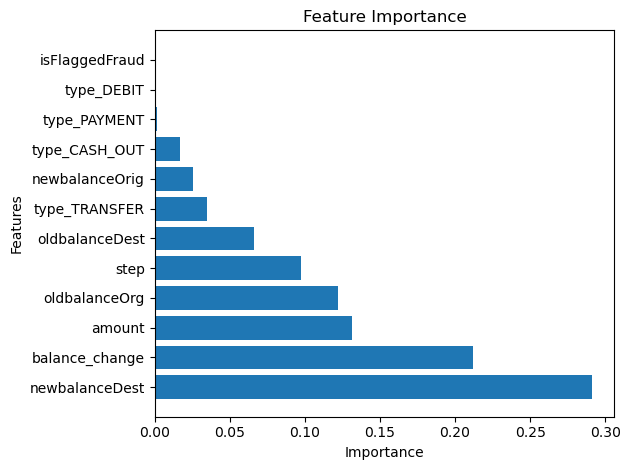

In [30]:
# Feature importance is a measure of how much each feature contributes to the model's decision-making process. 
# It helps us understand which features are more influential in making predictions.
plt.barh(sorted_features, feature_importance[sorted_indices])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### Describe your fraud detection model in elaboration.
- Data Collection and Preprocessing
    - Transactional data is collected from various sources, such as credit card transactions, bank transfers, or online payments.
    - The data is preprocessed to handle missing values, outliers, and format conversions. 
- Feature Engineering
    - Features are extracted from the transactional data to represent each transaction.
- Data Splitting
    - The dataset is split into training and testing sets. The training set is used to train the model, and the testing set is used to evaluate its performance on unseen data.
- Handling Imbalanced Data (if applicable)
    - Fraudulent transactions are often rare compared to legitimate ones, leading to class imbalance in the data.
    - Techniques like oversampling, undersampling, or using synthetic data can be applied to balance the classes and improve the model's performance.
- Model Training
    - Various machine learning algorithms can be used for fraud detection, such as RandomForest, Logistic Regression, Gradient Boosting, Neural Networks, or Anomaly Detection models.
    - The model is trained on the training data using the features and the corresponding labels.
- Model Evaluation
    - The model's performance is evaluated on the testing set using metrics like accuracy, precision, recall, F1-score, ROC-AUC, and others.
    - The evaluation helps in understanding how well the model generalizes to unseen data and its ability to distinguish between fraudulent and non-fraudulent transactions.
    
### How did you select variables to be included in the model?
The variables to be included in the model were selected based on some initial data preprocessing and feature engineering steps. Here's how the variables were selected:

- Data Preprocessing: The code drops two columns, 'nameOrig' and 'nameDest,' from the dataset using data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True). These columns might not provide meaningful information for the model as they represent customer names, which are likely unique for each transaction.
- Feature Engineering: 
    - The code performs one-hot encoding for the 'type' column using pd.get_dummies(data, columns=['type'], drop_first=True). This converts the categorical variable 'type' into binary dummy variables for each transaction type (CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER).
    - A new feature 'balance_change' is created as the difference between the 'newbalanceOrig' and 'oldbalanceOrg' columns using data['balance_change'] = data['newbalanceOrig'] - data['oldbalanceOrg'].
    
After these preprocessing and feature engineering steps, the dataset is ready for model training. The features used for the model are the columns in the data_no_outliers DataFrame, which include:

- All the one-hot encoded 'type' columns (binary dummy variables for transaction types).
- The 'step' column representing the time step of the transaction.
- The 'amount' column representing the amount of the transaction.
- The 'oldbalanceOrg' and 'newbalanceOrig' columns representing the initial and new balances of the customer initiating the transaction.
- The 'oldbalanceDest' and 'newbalanceDest' columns representing the initial and new balances of the recipient of the transaction.
- The 'balance_change' column representing the difference between the old and new balances of the customer initiating the transaction.
- These selected features are used to train the RandomForestClassifier for fraud detection.

### What are the key factors that predict fraudulent customer?
Key factors that can be predictive of fraudulent customers:

- Abnormal Transaction Frequency: Fraudulent customers may engage in an unusually high number of transactions in a short period or conduct transactions at odd hours.
- Abnormal Transaction Amounts: Fraudulent transactions often involve unusually large or small amounts compared to typical transactions.
- New Accounts: Fraudulent customers may create new accounts to carry out fraudulent activities rather than using existing ones.
- Unusual Transaction Patterns: Fraudulent customers may exhibit patterns that deviate from normal behavior, such as transferring funds to multiple accounts in quick succession.
- Historical Fraud Patterns: Identifying recurring fraud patterns from historical data can be used to predict future fraudulent activities.

### Do these factors make sense? If yes, How? If not, How not?
Yes! Each of these factors provides valuable insights into suspicious behavior that can be indicative of fraudulent activities.
- Abnormal Transaction Frequency: Fraudsters often conduct a high volume of transactions in a short period to maximize their gains and avoid detection. Unusually frequent transactions can be a red flag for potential fraud.
- Abnormal Transaction Amounts: Fraudulent transactions tend to deviate from the typical transaction amounts seen in legitimate behavior. Large amounts may indicate attempts to steal significant funds, while small amounts could be used for testing vulnerabilities.
- New Accounts: Creating new accounts is a common tactic for fraudsters to avoid detection and disguise their activities. Detecting a high number of new accounts can help identify potentially fraudulent behavior.
- Unusual Transaction Patterns: Fraudulent customers may exhibit patterns that differ from normal, legitimate behavior. For example, transferring funds to multiple unrelated accounts in quick succession may indicate attempts to launder money or distribute funds to avoid detection.
- Historical Fraud Patterns: Analyzing historical data for recurring fraud patterns can help predict and prevent future fraudulent activities. Recognizing similar patterns can assist in identifying suspicious behavior before it escalates.

### Assuming these actions have been implemented, how would you determine if they work?
To determine if the implemented fraud detection models work effectively, we need to evaluate their performance using appropriate evaluation metrics and validation techniques. Here are the steps to assess the model's performance:

- Holdout Validation:
Split the dataset into training and testing sets using techniques like train-test split or k-fold cross-validation. The training set is used to train the model, and the testing set is used to evaluate its performance on unseen data.
- Evaluation Metrics:
Calculate a set of evaluation metrics to assess the model's performance. Common metrics for binary classification (fraud vs. non-fraud)
- Confusion Matrix:
Analyze the confusion matrix to understand the number of true positives, true negatives, false positives, and false negatives. This helps in gaining insights into the model's performance in different scenarios.
- Feature Importance:
Investigate feature importance to identify the key factors influencing the model's predictions. This helps understand which features contribute most to identifying fraudulent transactions.

### What kind of prevention should be adopted while company update its infrastructure?

When a financial company updates its infrastructure for fraud detection, it should consider implementing a combination of technical and procedural measures to enhance its prevention capabilities. Here are some key prevention strategies:

- Advanced Authentication and Authorization:
    - Implement multi-factor authentication (MFA) for customer logins to ensure that only authorized users can access accounts and perform transactions.
    - Utilize strong password policies and enforce regular password updates.
- Real-time Transaction Monitoring:
    - Deploy real-time transaction monitoring systems to detect and flag potentially fraudulent transactions as they occur.
- Anomaly Detection:
    - Implement anomaly detection algorithms to identify unusual behaviors or patterns that deviate significantly from normal customer behavior.
- Data Encryption and Secure Communication:
    - Encrypt sensitive data, including customer information, account details, and transaction data, to prevent unauthorized access in case of data breaches.
 